# Crypto-Correlations

The goal of this analysis is to create a correlation matrix for these crypto-currencies. 

In [1]:
import pandas as pd
from pandas.plotting import lag_plot
import numpy as np
import sklearn as sk
from sklearn import preprocessing as pr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.signal import correlate
from scipy.stats.mstats import spearmanr
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_pacf

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data Handling
 
 ### Data representation and a quick clean

In [2]:
crypto = {}

crypto['bitcoin'] = pd.read_csv('../input/cryptocurrencypricehistory/bitcoin_price.csv')
crypto['bitcoin_cash'] = pd.read_csv("../input/cryptocurrencypricehistory/bitcoin_cash_price.csv")
crypto['dash'] = pd.read_csv("../input/cryptocurrencypricehistory/dash_price.csv")
crypto['ethereum'] = pd.read_csv("../input/cryptocurrencypricehistory/ethereum_price.csv")
crypto['iota'] = pd.read_csv("../input/cryptocurrencypricehistory/iota_price.csv")
crypto['litecoin'] = pd.read_csv("../input/cryptocurrencypricehistory/litecoin_price.csv")
crypto['monero'] = pd.read_csv("../input/cryptocurrencypricehistory/monero_price.csv")
crypto['nem'] = pd.read_csv("../input/cryptocurrencypricehistory/nem_price.csv")
crypto['neo'] = pd.read_csv("../input/cryptocurrencypricehistory/neo_price.csv")
crypto['numeraire'] = pd.read_csv("../input/cryptocurrencypricehistory/numeraire_price.csv")
crypto['ripple'] = pd.read_csv("../input/cryptocurrencypricehistory/ripple_price.csv")
crypto['stratis'] = pd.read_csv("../input/cryptocurrencypricehistory/stratis_price.csv")
crypto['waves'] = pd.read_csv("../input/cryptocurrencypricehistory/waves_price.csv")

In [3]:
# For this analysis I will only be looking at closing price to make things more manageable
for coin in crypto:
    for column in crypto[coin].columns:
        if column not in ['Date', 'Close']:
            crypto[coin] = crypto[coin].drop(column, 1)
    # Make date the datetime type and reindex
    crypto[coin]['Date'] = pd.to_datetime(crypto[coin]['Date'])
    crypto[coin] = crypto[coin].sort_values('Date')
    crypto[coin] = crypto[coin].set_index(crypto[coin]['Date'])
    crypto[coin] = crypto[coin].drop('Date', 1)

In [4]:
for coin in crypto:
    print(coin, len(crypto[coin]))

bitcoin 1592
bitcoin_cash 45
dash 1300
ethereum 761
iota 85
litecoin 1592
monero 1203
nem 889
neo 362
numeraire 30
ripple 1494
stratis 390
waves 461


### Note: 
The coins numeraire, iota, and bitcoin_cash all are relatively young and therefore do not have many data points. I will omit these currencies and for the time being consider only the most recent 350 data points for the remaining currencies.

In [5]:
del crypto['bitcoin_cash'], crypto['numeraire'], crypto['iota']

In [6]:
cryptoAll = {} # for later on

for coin in crypto:
    cryptoAll[coin] = crypto[coin]
    crypto[coin] = crypto[coin][-350:]

## Goal:

 As previously stated, the goal of this analysis is to create a correlation matrix for these currencies. One way to find correlation between timeseries is to look at *cross-correlation* of the timeseries. Cross-correlation is computed between two timeseries using a lag, so when creating the correlation matrix I will specify the correlation as well as the lag.
 
 Before computing the cross correlation, it is important to have wide-sense station (often just called stationary) data. There are a few ways to make data stationary-- one of which is through differencing. But even after this it is famously difficult to avoid spurious correlations between timeseries data that are often caused by autocorrelation. See this article for an in depth analysis of how spurious correlations arise and how to avoid them: https://link.springer.com/article/10.3758/s13428-015-0611-2.
 
 For now I employ daily differencing (as it is not seasonal) and test for stationarity to prepare for cross correlation testing.

In [7]:
# Differencing
for coin in crypto:
    crypto[coin]['CloseDiff'] = crypto[coin]['Close'].diff().fillna(0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Graphing

Now lets take a preliminary look at how our graph looks. Further steps may have to be taken to make the data stationary.

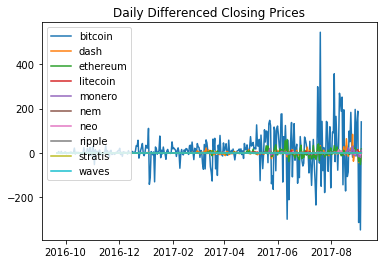

In [8]:
for coin in crypto:
    plt.plot(crypto[coin]['CloseDiff'], label=coin)
plt.legend(loc=2)
plt.title('Daily Differenced Closing Prices')
plt.show()

### Note:
Here we see that one of the coins (bitcoin) has much larger spikes than the other coins. While this may still have given us stationarity, it may be useful to also look at the percentage change per day of the timeseries.

In [9]:
# Percent Change
for coin in crypto:
    crypto[coin]['ClosePctChg'] = crypto[coin]['Close'].pct_change().fillna(0)
    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


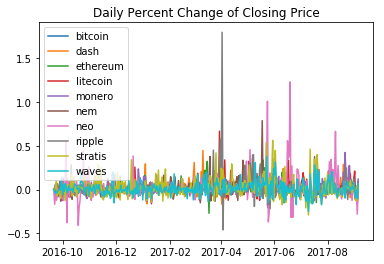

In [10]:
for coin in crypto:
    plt.plot(crypto[coin]['ClosePctChg'], label=coin)
plt.legend(loc=2)
plt.title('Daily Percent Change of Closing Price')
plt.show()

### Note:
As before, we still have some very large peaks, but overall the data looks more contained than previously. Most importantly, we do not have a single coin dominating the others.

Focus on one particular part of the graph to get an idea of any correlation going on.

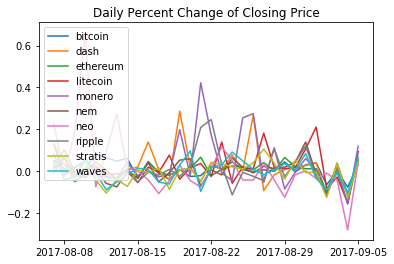

In [11]:
for coin in crypto:
    plt.plot(crypto[coin]['ClosePctChg'][-30:], label=coin)
plt.legend(loc=2)
plt.title('Daily Percent Change of Closing Price')
plt.show()

### Note:
Looks here as if we do in fact have some correlation going on, which is what we were hoping for.

It is also important to note that a number of other types of differencing or normalizations could have been applied. As this is only a preliminary analysis, this may not end up being the best way to prepare the data.

## Stationarity

We can test for stationarity by using *unit root tests*. One of which is the Augmented Dickey-Fuller Test. Dickey Fuller utilizes the following regression.

$$ Y'_t \space = \space \phi Y_{t-1} \space + \space b_1 Y'_{t-1} \space + \space b_2 Y'_{t-2} \space +...+ \space b_p Y'_{t-p} $$
$$ $$
$$ Y'_t \space = \space Y_t \space - \space Y_{t-1} $$

Using the Augmented Dickey Fuller test, we look at the following statistic.

$$ DF_t \space = \space \frac{\hat{\phi}}{SE(\hat{\phi}}) $$

Then this statistic is compared to a table given by Dickey Fuller. Given the number of samples, we can guess with a % certainty whether or not our data is stationary.

$$ H_{0} \space : data \space is \space nonstationary $$
$$ H_{A} \space : data \space is \space stationary $$

To check these hypotheses, we look at the p-value of our given statistic using table (web.sgh.waw.pl/~mrubas/EP/TabliceStatystyczneDF.doc). On the table we look at model 2 with 250 < n < 500. Form here we can see that in order to know with 5% certainty whether or not our data is stationary, we can compare our $ DF_t $ statistic to the values 3.46 and 3.44.

In [12]:
for coin in crypto:
    print('\n',coin)
    adf = adfuller(crypto[coin]['ClosePctChg'][1:])
    print(coin, 'ADF Statistic: %f' % adf[0])
    print(coin, 'p-value: %f' % adf[1])
    print(coin, 'Critical Values', adf[4]['1%'])
    print(adf)


 bitcoin
bitcoin ADF Statistic: -18.831732
bitcoin p-value: 0.000000
bitcoin Critical Values -3.44928158488
(-18.831732453592416, 0.0, 0, 348, {'1%': -3.4492815848836296, '5%': -2.8698813715275406, '10%': -2.5712138845950587}, -1211.8452977607994)

 dash
dash ADF Statistic: -18.367991
dash p-value: 0.000000
dash Critical Values -3.44928158488
(-18.367990617952859, 2.2208965733307594e-30, 0, 348, {'1%': -3.4492815848836296, '5%': -2.8698813715275406, '10%': -2.5712138845950587}, -807.29417244100796)

 ethereum
ethereum ADF Statistic: -17.719534
ethereum p-value: 0.000000
ethereum Critical Values -3.44928158488
(-17.719534414810685, 3.4732756997705516e-30, 0, 348, {'1%': -3.4492815848836296, '5%': -2.8698813715275406, '10%': -2.5712138845950587}, -812.4901563682406)

 litecoin
litecoin ADF Statistic: -6.863228
litecoin p-value: 0.000000
litecoin Critical Values -3.44967319331
(-6.8632276169541395, 1.5828678323876899e-09, 7, 341, {'1%': -3.4496731933105922, '5%': -2.8700533746644323, '10

In [13]:
for coin in crypto:
    print('\n',coin)
    adf = adfuller(crypto[coin]['CloseDiff'][1:])
    print(coin, 'ADF Statistic: %f' % adf[0])
    print(coin, 'p-value: %f' % adf[1])
    print(coin, 'Critical Values', adf[4]['1%'])
    print(adf)


 bitcoin
bitcoin ADF Statistic: -9.424382
bitcoin p-value: 0.000000
bitcoin Critical Values -3.44944745634
(-9.4243817473604956, 5.3957012201832083e-16, 3, 345, {'1%': -3.4494474563375737, '5%': -2.8699542285903887, '10%': -2.5712527305187987}, 3878.2883289519154)

 dash
dash ADF Statistic: -5.178264
dash p-value: 0.000010
dash Critical Values -3.44996298193
(-5.1782635778158248, 9.7363510815150506e-06, 12, 336, {'1%': -3.449962981927952, '5%': -2.8701806424201628, '10%': -2.5713734527352607}, 2452.0577015265849)

 ethereum
ethereum ADF Statistic: -18.068995
ethereum p-value: 0.000000
ethereum Critical Values -3.44928158488
(-18.068994893631459, 2.6076413703622586e-30, 0, 348, {'1%': -3.4492815848836296, '5%': -2.8698813715275406, '10%': -2.5712138845950587}, 2536.8861934247484)

 litecoin
litecoin ADF Statistic: -7.579637
litecoin p-value: 0.000000
litecoin Critical Values -3.44978807499
(-7.5796370049245843, 2.7033287996106029e-11, 9, 339, {'1%': -3.4497880749874628, '5%': -2.870103

### Note:
Here we see that  our data is very stationary! This is clear because of the extremely low p-values.. 

It is important here to note there are other wasy to detrend other than looking at differenced data or percent change. However some of these methods would not have proven fruitful for this data set. Take for example using the residuals of this data based on a simple linear regression. This can be easily done using scikit learn's linear regression tool.

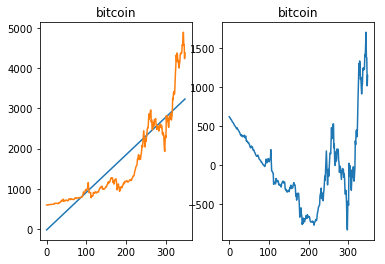

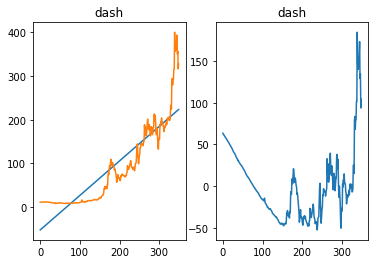

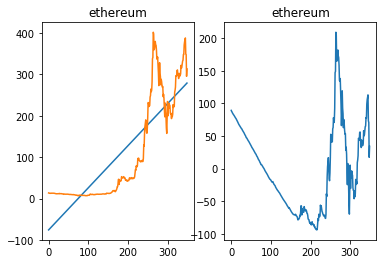

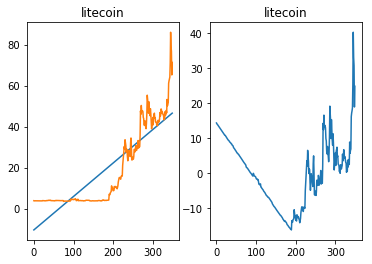

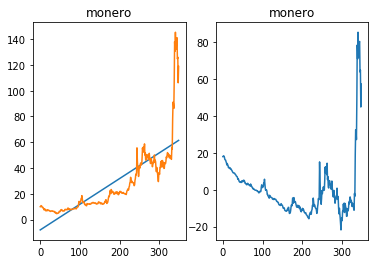

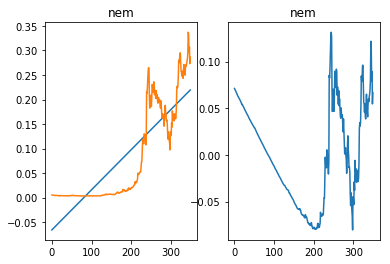

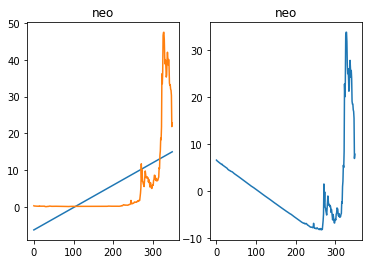

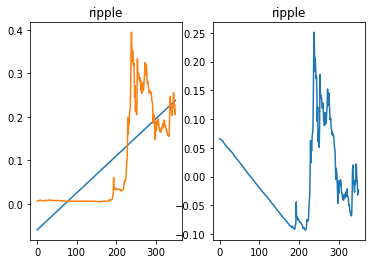

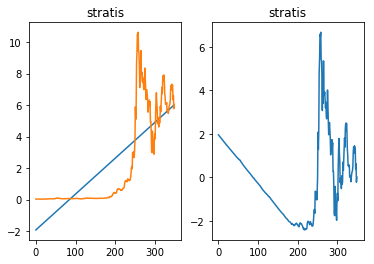

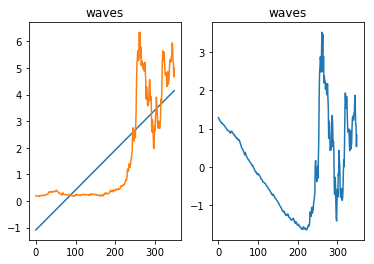

In [14]:
for coin in crypto:
    model = LinearRegression()
    model.fit(np.arange(350).reshape(-1,1), crypto[coin]['Close'].values)
    trend = model.predict(np.arange(350).reshape(-1,1))
    plt.subplot(1, 2, 1)
    plt.plot(trend, label='trend')
    plt.plot(crypto[coin]['Close'].values)
    plt.title(coin)
    
    plt.subplot(1, 2, 2)
    plt.plot(crypto[coin]['Close'].values - trend, label='residuals')
    plt.title(coin)
    
    plt.show()

### Note:
We are getting poor results, as many of these currencies only started gaining traction recently, this shows that the preferred method was what was done originally.

## Correlations

Now we will look at the cross correlations between the different series. To do this scipy's correlate function will be used. The cross-correlation will tell us if we should lag one of the series. Cross-correlation is often used in signal process to match signals.

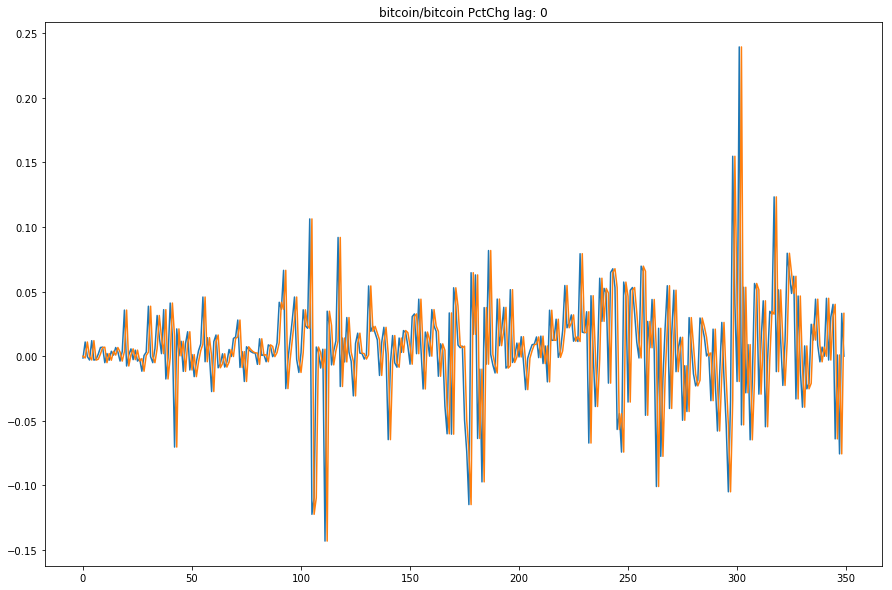

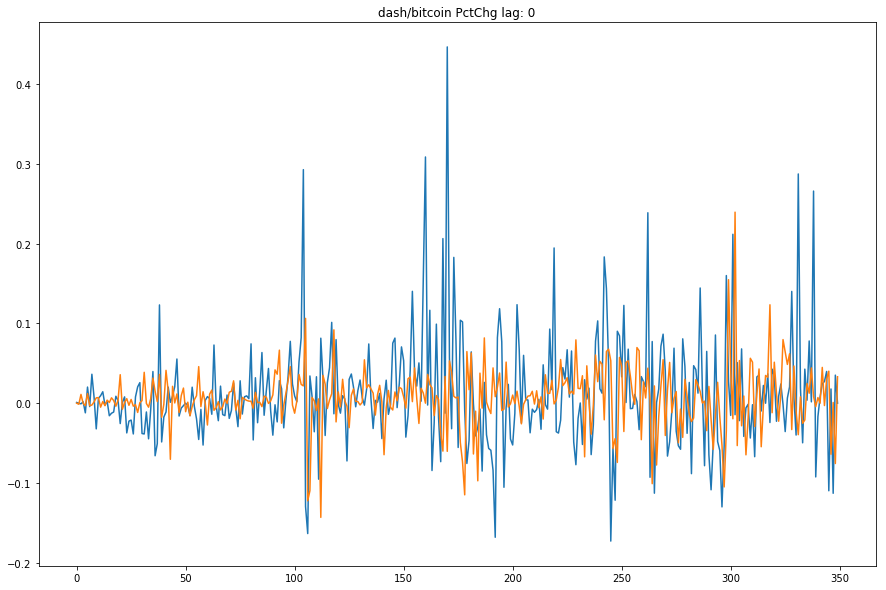

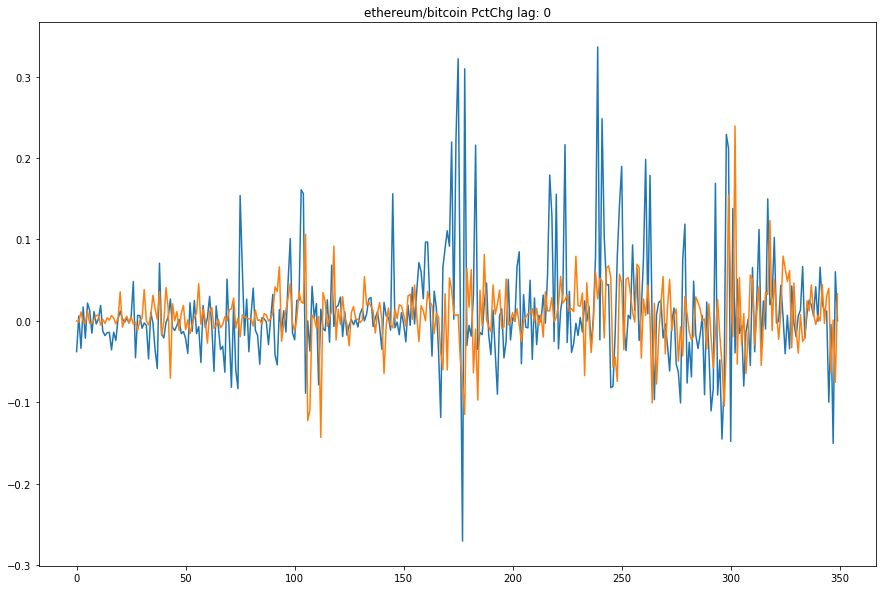

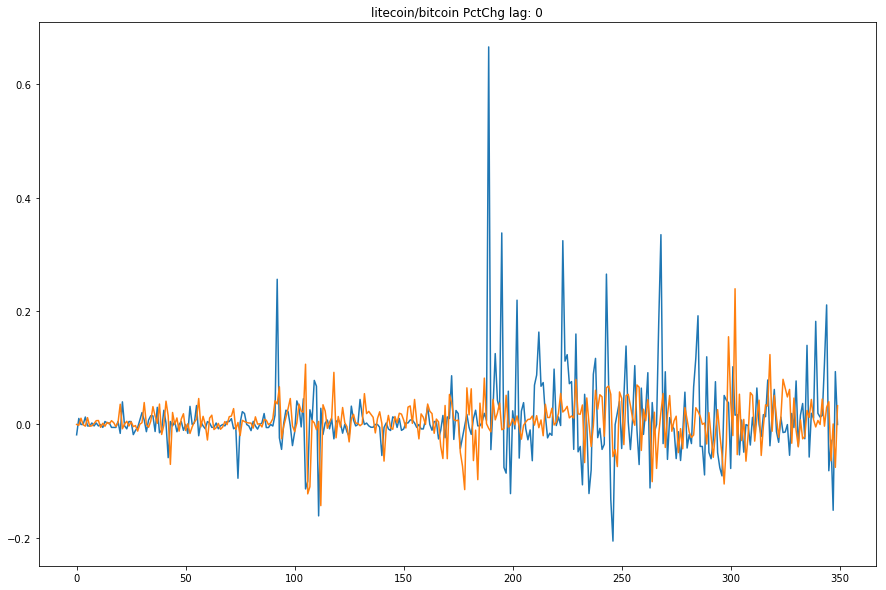

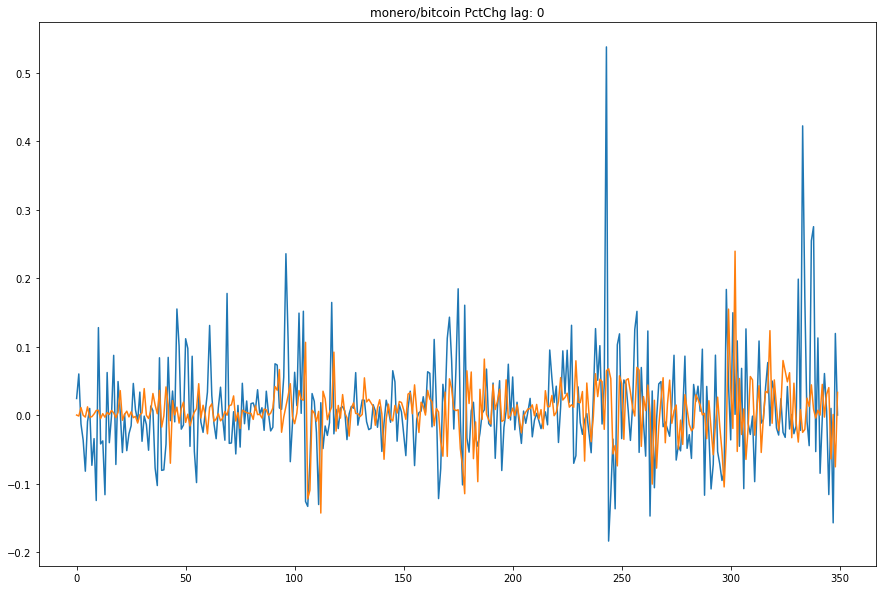

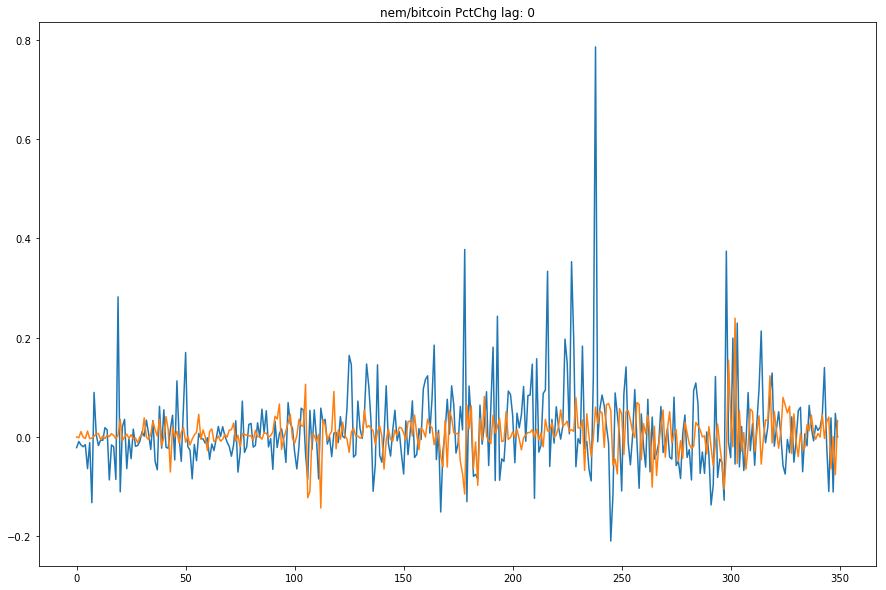

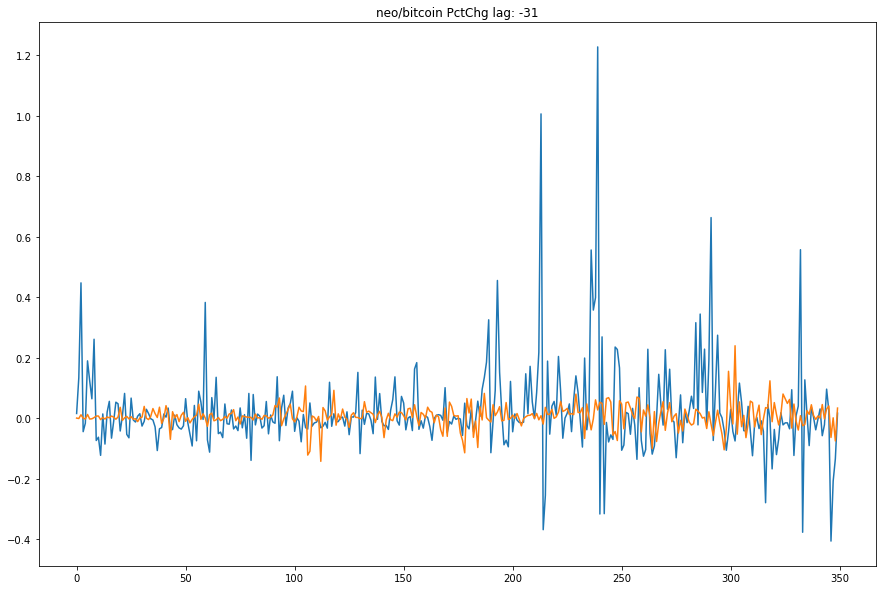

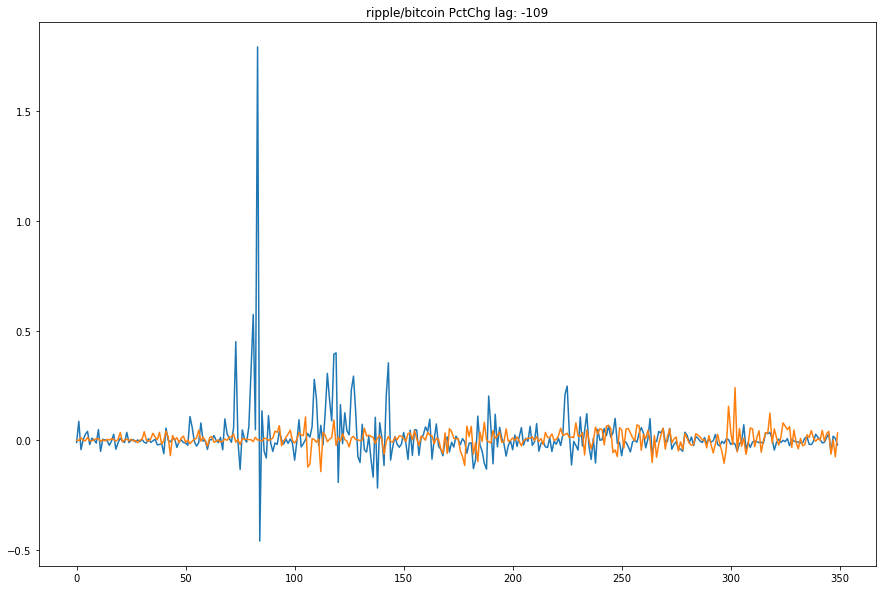

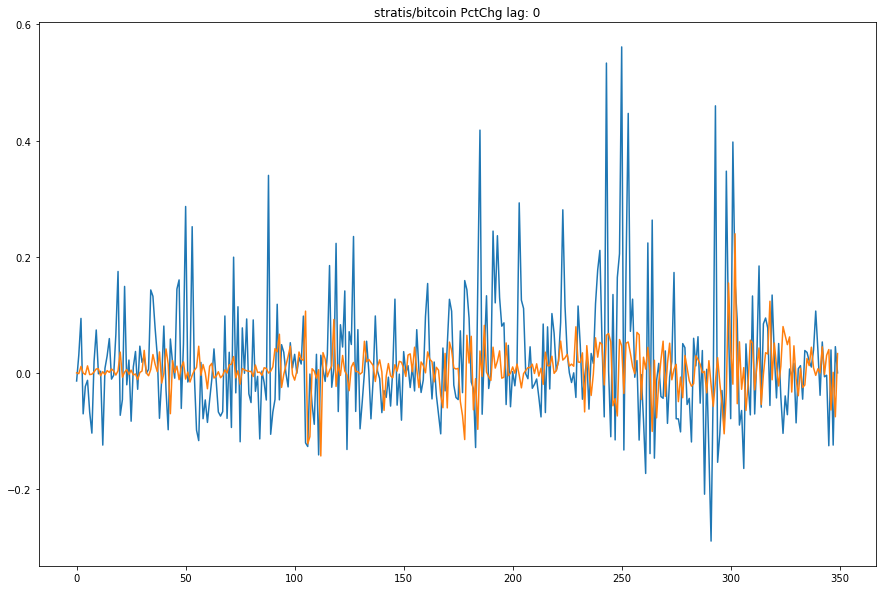

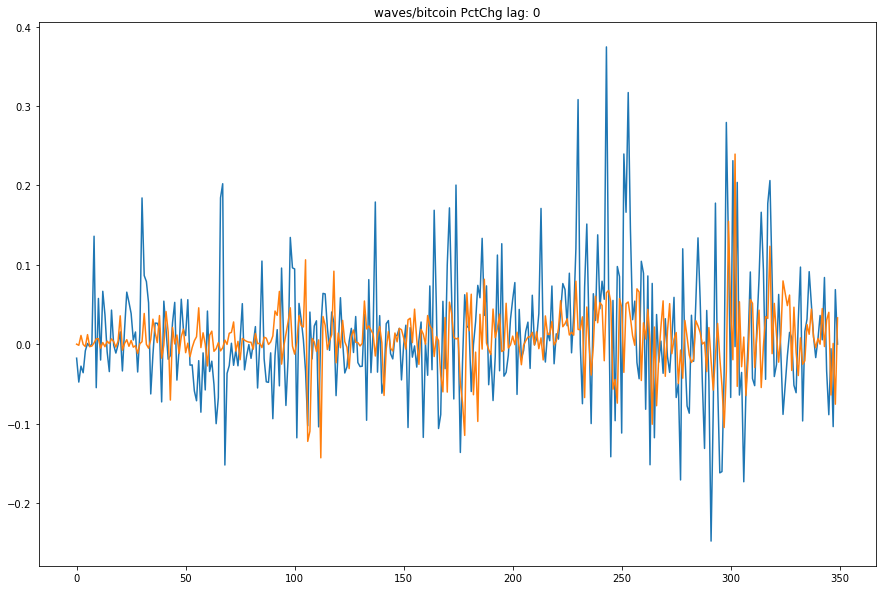

In [15]:
corrBitcoin = {}
corrDF = pd.DataFrame()

for coin in crypto: 
    corrBitcoin[coin] = correlate(crypto[coin]['ClosePctChg'], crypto['bitcoin']['ClosePctChg'])
    lag = np.argmax(corrBitcoin[coin])
    laggedCoin = np.roll(crypto[coin]['ClosePctChg'], shift=int(np.ceil(lag)))
    corrDF[coin] = laggedCoin
    
    plt.figure(figsize=(15,10))
    plt.plot(laggedCoin)
    plt.plot(crypto['bitcoin']['ClosePctChg'].values)
    title = coin + '/bitcoin PctChg lag: ' + str(lag-349)
    plt.title(title)

    plt.show()

Now that we have done that we will look at the correlations among these currencies. 
We will compute the correlations using three different methods: pearson, spearman, and kendall.

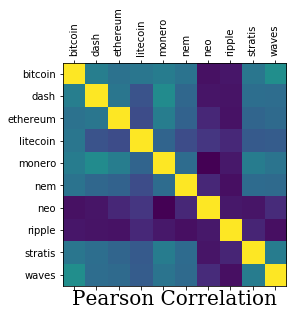

,bitcoin,dash,ethereum,litecoin,monero,nem,neo,ripple,stratis,waves
bitcoin,1.000000,0.387525,0.333383,0.347812,0.376937,0.336289,-0.022151,-0.005463,0.348967,0.458291
dash,0.387525,1.000000,0.348184,0.202866,0.447403,0.284776,-0.010468,-0.013311,0.316658,0.309898
ethereum,0.333383,0.348184,1.000000,0.175537,0.381646,0.266816,0.049736,-0.020901,0.278187,0.299396
litecoin,0.347812,0.202866,0.175537,1.000000,0.273222,0.177181,0.098873,0.052456,0.233604,0.241150
monero,0.376937,0.447403,0.381646,0.273222,1.000000,0.308245,-0.071413,-0.002972,0.378678,0.341833
nem,0.336289,0.284776,0.266816,0.177181,0.308245,1.000000,0.046789,-0.026707,0.302735,0.297583
neo,-0.022151,-0.010468,0.049736,0.098873,-0.071413,0.046789,1.000000,-0.003353,-0.012766,0.061057
ripple,-0.005463,-0.013311,-0.020901,0.052456,-0.002972,-0.026707,-0.003353,1.000000,0.039321,-0.028354
stratis,0.348967,0.316658,0.278187,0.233604,0.378678,0.302735,-0.012766,0.039321,1.000000,0.378534
waves,0.458291,0.309898,0.299396,0.241150,0.341833,0.297583,0.061057,-0.028354,0.378534,1.000000


In [16]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }

plt.matshow(corrDF.corr(method='pearson'))
plt.xticks(range(10), corrDF.columns.values, rotation='vertical')
plt.yticks(range(10), corrDF.columns.values)
plt.xlabel('Pearson Correlation', fontdict=font)
plt.show()
corrDF.corr(method='pearson')

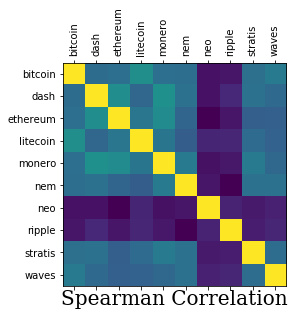

,bitcoin,dash,ethereum,litecoin,monero,nem,neo,ripple,stratis,waves
bitcoin,1.000000,0.316791,0.329353,0.462786,0.325833,0.322689,-0.008338,0.004822,0.332455,0.380201
dash,0.316791,1.000000,0.462064,0.289179,0.474220,0.336014,-0.007362,0.063024,0.334794,0.301827
ethereum,0.329353,0.462064,1.000000,0.356799,0.453255,0.287617,-0.059308,0.005984,0.262176,0.265676
litecoin,0.462786,0.289179,0.356799,1.000000,0.352459,0.253884,0.052311,0.055916,0.311864,0.275568
monero,0.325833,0.474220,0.453255,0.352459,1.000000,0.378433,-0.011695,0.009667,0.372242,0.293036
nem,0.322689,0.336014,0.287617,0.253884,0.378433,1.000000,0.006115,-0.057368,0.341412,0.339613
neo,-0.008338,-0.007362,-0.059308,0.052311,-0.011695,0.006115,1.000000,0.043523,0.017468,0.039370
ripple,0.004822,0.063024,0.005984,0.055916,0.009667,-0.057368,0.043523,1.000000,0.026313,0.055809
stratis,0.332455,0.334794,0.262176,0.311864,0.372242,0.341412,0.017468,0.026313,1.000000,0.317652
waves,0.380201,0.301827,0.265676,0.275568,0.293036,0.339613,0.039370,0.055809,0.317652,1.000000


In [17]:
plt.matshow(corrDF.corr(method='spearman'))
plt.xticks(range(10), corrDF.columns.values, rotation='vertical')
plt.yticks(range(10), corrDF.columns.values)
plt.xlabel('Spearman Correlation', fontdict=font)
plt.show()
corrDF.corr(method='spearman')

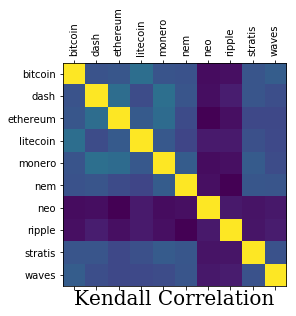

,bitcoin,dash,ethereum,litecoin,monero,nem,neo,ripple,stratis,waves
bitcoin,1.000000,0.226565,0.236618,0.336983,0.231015,0.221584,-0.005878,0.004077,0.232296,0.266382
dash,0.226565,1.000000,0.330413,0.200359,0.337907,0.235178,-0.003553,0.044488,0.234264,0.208128
ethereum,0.236618,0.330413,1.000000,0.252938,0.321697,0.197976,-0.040493,0.003684,0.184815,0.183076
litecoin,0.336983,0.200359,0.252938,1.000000,0.245702,0.178840,0.034833,0.035784,0.215333,0.189057
monero,0.231015,0.337907,0.321697,0.245702,1.000000,0.264155,-0.007024,0.002636,0.258527,0.201215
nem,0.221584,0.235178,0.197976,0.178840,0.264155,1.000000,0.003750,-0.039018,0.239075,0.235501
neo,-0.005878,-0.003553,-0.040493,0.034833,-0.007024,0.003750,1.000000,0.029391,0.012428,0.025035
ripple,0.004077,0.044488,0.003684,0.035784,0.002636,-0.039018,0.029391,1.000000,0.017340,0.036857
stratis,0.232296,0.234264,0.184815,0.215333,0.258527,0.239075,0.012428,0.017340,1.000000,0.221063
waves,0.266382,0.208128,0.183076,0.189057,0.201215,0.235501,0.025035,0.036857,0.221063,1.000000


In [18]:
plt.matshow(corrDF.corr(method='kendall'))
plt.xticks(range(10), corrDF.columns.values, rotation='vertical')
plt.yticks(range(10), corrDF.columns.values)
plt.xlabel('Kendall Correlation', fontdict = font)
plt.show()
corrDF.corr(method='kendall')

### Note:
We see here that with all of these correlation methods we get about the same results, but with slightly different magnitudes.
Also we should note that there are *no* correlations greater than .5
This is contrary to what may be found if we were to for example take the correlation of the nonstationary datasets. This leads me to believe that I have avoided spurious correlations between currencies. Also note that only two of the currencies showed to have better correlations with lagged data. This makes sense as these currencies have shown to be very responsive to media in the recent past.

Thanks for reading I hope you enjoyed this notebook. If you have any suggestions or if I missed anything please let me know in the comments!